<a href="https://colab.research.google.com/github/lprockop/NLPGroup10/blob/main/PrelimAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP Final Project

## Last updated:
04/14/23, Lyle

### Current state:
  
Data is imported and eFMD scores are run.  
eFMD already includes necessary preprocessing steps (removing special characters and lowercasing letters) so those steps are kept in at the end in case we want to use them for other scorers/analyses.

Update as of 04/09:
- Ran vice-virtue scoring 
- Graphed sanctity.vice scores

### Note: 
After making any updates, please File > Save a Copy in GitHub to update the shared GitHub project

### Import data

In [7]:
#read in csvs (note: I've downloaded these from the Data Google folder and re-uploaded in this runtime)
import pandas as pd
nyt = pd.read_csv('nyt_abortion_1200.csv').drop(columns='Unnamed: 0')
sc = pd.read_csv('scotus_abortion.csv').drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])

#add year column to NYT dataset
year = []
for i in nyt.pub_date:
  year.append(int(i[0:4]))
nyt['year'] = year

### Sentiment analysis using eFMD

In [ ]:
#install necessary modules
!pip install -U pip setuptools wheel
!pip install -U spacy==3.4.0
!python -m spacy download en_core_web_sm
!pip install git+https://github.com/medianeuroscience/emfdscore.git

In [9]:
#import packages we'll need
import pandas as pd 
import numpy as np

In [10]:
#format text columns in the proper format for eFMD...
#...in NYT dataframe
template_input_nyt = pd.DataFrame(nyt['abstract']).sort_values('abstract', ascending=False).dropna()
template_input_nyt = template_input_nyt[template_input_nyt['abstract']!=''].sort_values('abstract').rename({'abstract':0}, axis=1)
template_input_nyt = template_input_nyt.reset_index().drop('index', axis=1)
#...in SC dataframe
template_input_sc = pd.DataFrame(sc['text']).sort_values('text', ascending=False).dropna()
template_input_sc = template_input_sc[template_input_sc['text']!=''].sort_values('text').rename({'text':0}, axis=1)
template_input_sc = template_input_sc.reset_index().drop('index', axis=1)

In [11]:
#import and run eFMD scoring
from emfdscore.scoring import score_docs 
num_docs_nyt = len(template_input_nyt)
num_docs_sc = len(template_input_sc)
DICT_TYPE = 'emfd'
PROB_MAP = 'all'
SCORE_METHOD = 'bow'
OUT_METRICS = 'sentiment'
#create new dfs to hold the results
df_nyt = score_docs(template_input_nyt, DICT_TYPE, PROB_MAP, SCORE_METHOD, OUT_METRICS, num_docs_nyt)
df_sc = score_docs(template_input_sc, DICT_TYPE, PROB_MAP, SCORE_METHOD, OUT_METRICS, num_docs_sc)
#combine dfs that hold the initial data with the results
nyt_df = pd.concat((nyt, df_nyt), axis=1)
sc_df = pd.concat((sc, df_sc), axis=1)
#examine output for SC
sc_df.head()

Processed: 1189 100% |❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤| Elapsed Time: 0:00:16 Time:  0:00:16
Processed: 35 100% |❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤| Elapsed Time: 0:00:34 Time:  0:00:34


,Unnamed: 0.2,author_name,category,per_curiam,case_name,date_filed,federal_cite_one,absolute_url,cluster,year_filed,...,authority_p,sanctity_p,care_sent,fairness_sent,loyalty_sent,authority_sent,sanctity_sent,moral_nonmoral_ratio,f_var,sent_var
0,0,Justice Blackmun,majority,False,Roe v. Wade,1973-01-22,NaN,https://www.courtlistener.com/opinion/108713/r...,https://www.courtlistener.com/api/rest/v3/clus...,1973,...,0.104120,0.088544,-0.078838,-0.049894,-0.024090,-0.022071,-0.050575,0.881183,0.000073,0.000541
1,1,Justice O'Connor and Kennedy and Souter,majority,False,Planned Parenthood of Southeastern Pa. v. Casey,1992-06-29,NaN,https://www.courtlistener.com/opinion/112786/p...,NaN,1992,...,0.104372,0.092741,-0.071447,-0.045651,-0.026034,-0.034011,-0.047386,1.399520,0.000089,0.000296
2,2,Justice Stewart,concurring,False,Roe v. Wade,1973-01-22,NaN,https://www.courtlistener.com/opinion/108713/r...,https://www.courtlistener.com/api/rest/v3/clus...,1973,...,0.104660,0.086185,-0.089379,-0.015917,-0.007430,-0.005189,-0.051946,1.174528,0.000169,0.001313
3,3,Justice Rehnquist,dissenting,False,Roe v. Wade,1973-01-22,NaN,https://www.courtlistener.com/opinion/108713/r...,https://www.courtlistener.com/api/rest/v3/clus...,1973,...,0.104747,0.082228,-0.089115,-0.024546,-0.029659,-0.038441,-0.071355,1.054968,0.000187,0.000795
4,4,per_curiam,per_curiam,True,Poelker v. Doe,1977-06-20,NaN,https://www.courtlistener.com/opinion/109712/p...,https://www.courtlistener.com/api/rest/v3/clus...,1977,...,0.105832,0.086574,-0.080738,-0.044666,-0.030372,-0.028697,-0.051229,1.013566,0.000106,0.000443


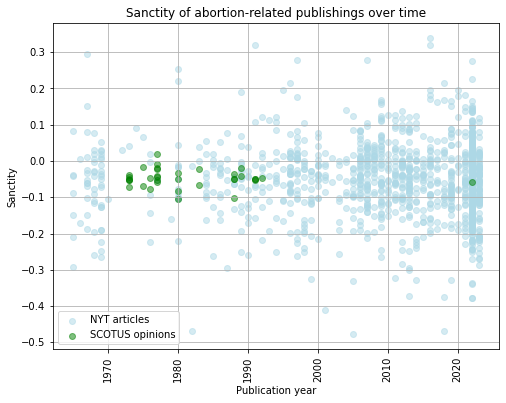

In [12]:
#visualize sanctity scores over time
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.scatter(nyt_df.year, nyt_df.sanctity_sent, alpha=0.5, color='lightblue', label='NYT articles')
plt.scatter(sc_df.year_filed, sc_df.sanctity_sent, alpha=0.5, color='green', label='SCOTUS opinions')
plt.legend()
plt.xticks(rotation=90)
plt.xlabel('Publication year')
plt.ylabel('Sanctity')
plt.title('Sanctity of abortion-related publishings over time')
plt.grid()
plt.show()

In [25]:
# running vice virtue analysis

from emfdscore.scoring import score_docs 

num_docs_nyt = len(template_input_nyt)
num_docs_sc = len(template_input_sc)

DICT_TYPE = 'mfd'
PROB_MAP = 'all'
SCORE_METHOD = 'bow'
OUT_METRICS = ''

#create new dfs to hold the results
df_nyt_v = score_docs(template_input_nyt, DICT_TYPE, PROB_MAP, SCORE_METHOD, OUT_METRICS, num_docs_nyt)
df_sc_v = score_docs(template_input_sc, DICT_TYPE, PROB_MAP, SCORE_METHOD, OUT_METRICS, num_docs_sc)
#combine dfs that hold the initial data with the results
nyt_df_v = pd.concat((nyt, df_nyt_v), axis=1)
sc_df_v = pd.concat((sc, df_sc_v), axis=1).drop(columns=['Unnamed: 0.2'])
#examine output for SC
sc_df_v.head()

Processed: 1189 100% |❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤| Elapsed Time: 0:00:23 Time:  0:00:23
Processed: 35 100% |❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤| Elapsed Time: 0:00:54 Time:  0:00:54


,author_name,category,per_curiam,case_name,date_filed,federal_cite_one,absolute_url,cluster,year_filed,scdb_id,...,authority.virtue,sanctity.virtue,care.vice,fairness.vice,loyalty.vice,authority.vice,sanctity.vice,moral,moral_nonmoral_ratio,f_var
0,Justice Blackmun,majority,False,Roe v. Wade,1973-01-22,NaN,https://www.courtlistener.com/opinion/108713/r...,https://www.courtlistener.com/api/rest/v3/clus...,1973,1972-048,...,0.332061,0.011450,0.039440,0.013995,0.017812,0.113232,0.003817,0.134860,0.058657,0.010225
1,Justice O'Connor and Kennedy and Souter,majority,False,Planned Parenthood of Southeastern Pa. v. Casey,1992-06-29,NaN,https://www.courtlistener.com/opinion/112786/p...,NaN,1992,1991-117,...,0.267380,0.010695,0.117647,0.030303,0.035651,0.049911,0.003565,0.160428,0.066548,0.006358
2,Justice Stewart,concurring,False,Roe v. Wade,1973-01-22,NaN,https://www.courtlistener.com/opinion/108713/r...,https://www.courtlistener.com/api/rest/v3/clus...,1973,1972-048,...,0.125000,0.000000,0.062500,0.000000,0.000000,0.093750,0.000000,0.187500,0.074592,0.007172
3,Justice Rehnquist,dissenting,False,Roe v. Wade,1973-01-22,NaN,https://www.courtlistener.com/opinion/108713/r...,https://www.courtlistener.com/api/rest/v3/clus...,1973,1972-048,...,0.209877,0.074074,0.098765,0.000000,0.012346,0.086420,0.012346,0.185185,0.043478,0.006070
4,per_curiam,per_curiam,True,Poelker v. Doe,1977-06-20,NaN,https://www.courtlistener.com/opinion/109712/p...,https://www.courtlistener.com/api/rest/v3/clus...,1977,1976-157,...,0.310000,0.000000,0.000000,0.010000,0.040000,0.030000,0.010000,0.200000,0.050556,0.011366


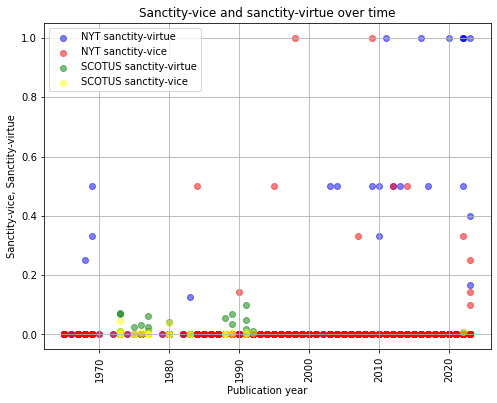

In [23]:
#visualize sanctity.vice over time
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.scatter(nyt_df.year, nyt_df_v['sanctity.virtue'], alpha=0.5, color='blue', label='NYT sanctity-virtue')
plt.scatter(nyt_df.year, nyt_df_v['sanctity.vice'], alpha=0.5, color='red', label='NYT sanctity-vice')
plt.scatter(sc_df.year_filed, sc_df_v['sanctity.virtue'], alpha=0.5, color='green', label='SCOTUS sanctity-virtue')
plt.scatter(sc_df.year_filed, sc_df_v['sanctity.vice'], alpha=0.5, color='yellow', label='SCOTUS sanctity-vice')
plt.legend()
plt.xticks(rotation=90)
plt.xlabel('Publication year')
plt.ylabel('Sanctity-vice, Sanctity-virtue')
plt.title('Sanctity-vice and sanctity-virtue over time')
plt.grid()
plt.savefig('san_vice_san_virtue.png')
plt.show()

# Prediction model

Given a corpus, what is the predicted sanctity score?

In [51]:
from utils import *

In [65]:
#CLEAN TEXT

df = pd.concat((sc_df[['text', 'sanctity_sent']], 
                nyt_df[['abstract', 'sanctity_sent']].rename(columns={'abstract':'text'})), 
               axis=0, ignore_index=True).dropna(how='any', axis=0)

print(df.shape)

text_clean = []
for i in df['text']:
    try:
        text_clean.append(clean_text(i))
    except:
        print(i)
df['text_clean'] = text_clean

(1213, 2)


In [67]:
#remove stopwords
df['text_remsw'] = df['text_clean'].apply(rem_sw)

#stem (this uses PorterStemmer)
df['text_stem'] = df['text_remsw'].apply(stem_fun)

#turn each corpus into df?

#vectorize
vec = vec_fun(df['text_stem'], 1, 1, 'tfidf', '')

#train test split df
X = vec
y = df['sanctity_sent']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=0)

#train RF model on train set
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor().fit(X_train, y_train)

#score RF model on test set
print(rf.score(X_test, y_test))
print(rf.feature_importances_)
print(sorted(rf.feature_importances_)[::-1][:3])

[0.00000000e+00 5.08052998e-06 2.17308782e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]


In [73]:
#tune hyperparams
from sklearn.model_selection import GridSearchCV

param_grid = {'n_estimators' : [10, 20, 30],
             'max_depth' : [10, 20, 30]}

grid = GridSearchCV(RandomForestRegressor(), param_grid=param_grid, cv=5).fit(X_train, y_train)
print('Best params: {}'.format(grid.best_params_))
print('Train set score: {}'.format(grid.score(X_train, y_train)))
print('Test set score: {}'.format(grid.score(X_test, y_test)))

Best params: {'max_depth': 10, 'n_estimators': 10}
Train set score: 0.19556266966331481
Test set score: -0.09771176128688985


# Archive

## Data cleaning (not necessary for eFMD)

In [ ]:
def clean_text(str_in):
    import re
    tmp = re.sub(r'[^\w]', " ",str_in).lower().strip().replace("  ", " ")
    return tmp

#### Clean NYT abstract

In [ ]:
abs_clean = []
for i in nyt.abstract:
  try:
    abs_clean.append(clean_text(i))
  except:
    abs_clean.append('')

nyt['abstract_clean'] = abs_clean
nyt = nyt[['pub_date', 'abstract_clean']]
nyt.head()

,pub_date,abstract_clean
0,2023-03-17T19:54:54+0000,cases in poland and texas bring legal vulnerab...
1,2023-03-18T02:30:36+0000,the law is the only one in the nation to prohi...
2,2023-03-08T11:46:02+0000,since roe v wade ended the battle over legal a...
3,2023-03-13T22:23:59+0000,six works in a lewis clark exhibition about he...
4,2023-03-14T19:44:31+0000,it was the first conviction of its type in the...


#### Clean Supreme Court decisions

In [ ]:
text_clean = []
for i in sc.text:
  try:
    text_clean.append(clean_text(i))
  except:
    text_clean.append('')

sc['text_clean'] = text_clean
sc = sc[['year_filed', 'text_clean']]
sc.head()

,year_filed,text_clean
0,1973,this texas federal appeal and its georgia comp...
1,1992,i liberty finds no refuge in a jurisprudence o...
2,1973,in 1963 this court in ferguson v skrupa 372 u ...
3,1973,the court s opinion brings to the decision of ...
4,1977,respondent jane doe an indigent sought unsucce...


### Plotting all variables

In [ ]:
import matplotlib.pyplot as plt

metrics = ['care_p', 'fairness_p', 'loyalty_p', 'authority_p', 'sanctity_p', 
'care_sent', 'fairness_sent', 'loyalty_sent', 'authority_sent',
'sanctity_sent', 'moral_nonmoral_ratio', 'f_var', 'sent_var']

for i in metrics:
  plt.figure(figsize=(6, 4))
  plt.scatter(nyt_df.year, nyt_df[i], alpha=0.5, color='lightblue', label='NYT articles')
  plt.scatter(sc_df.year_filed, sc_df[i], alpha=0.5, color='green', label='SCOTUS opinions')
  plt.legend()
  plt.xticks(rotation=90)
  plt.xlabel('Publication year')
  plt.ylabel(str(i))
  plt.title('{} of abortion-related NYC articles and SCOTUS opinions over time'.format(str(i)))
  plt.grid()
  plt.savefig('{}overtime.png'.format(str(i)))
  plt.show()

#### Note: scores that are calculated:


```
'care_p', 'fairness_p', 'loyalty_p', 'authority_p', 'sanctity_p', 
'care_sent', 'fairness_sent', 'loyalty_sent', 'authority_sent',
'sanctity_sent', 'moral_nonmoral_ratio', 'f_var', 'sent_var'
```

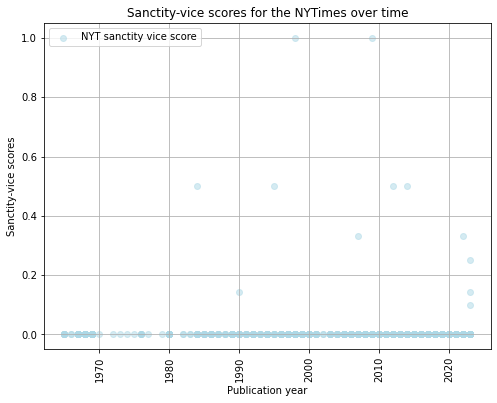

In [15]:
#visualize sanctity.vice over time
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.scatter(nyt_df.year, nyt_df_v['sanctity.vice'], alpha=0.5, color='lightblue', label='NYT sanctity vice score')
plt.legend()
plt.xticks(rotation=90)
plt.xlabel('Publication year')
plt.ylabel('Sanctity-vice scores')
plt.title('Sanctity-vice scores for the NYTimes over time')
plt.grid()
plt.show()

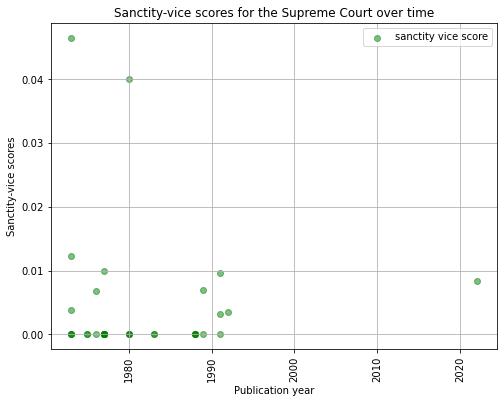

In [16]:
plt.figure(figsize=(8, 6))
plt.scatter(sc_df.year_filed, sc_df_v['sanctity.vice'], alpha=0.5, color='green', label='sanctity vice score')
plt.legend()
plt.xticks(rotation=90)
plt.xlabel('Publication year')
plt.ylabel('Sanctity-vice scores')
plt.title('Sanctity-vice scores for the Supreme Court over time')
plt.grid()
plt.show()

## Scrapped idea for prediction model - given SCOTUS sanctity score in a given year, what will NYT sanctity score be?

In [ ]:
#subset dfs, group by year

sc_tmp = pd.concat((sc_df_v[['sanctity.virtue', 'sanctity.vice', 'year_filed']], sc_df[['sanctity_sent']]), axis=1)
sc_tmp.shape

nyt_tmp = pd.concat((nyt_df_v[['sanctity.virtue', 'sanctity.vice', 'year']], nyt_df[['sanctity_sent']]), axis=1)
nyt_tmp.shape

sc_tmp = sc_tmp.groupby('year_filed').max() #can change this to mean, median, min, etc.
nyt_tmp = nyt_tmp.groupby('year').max()

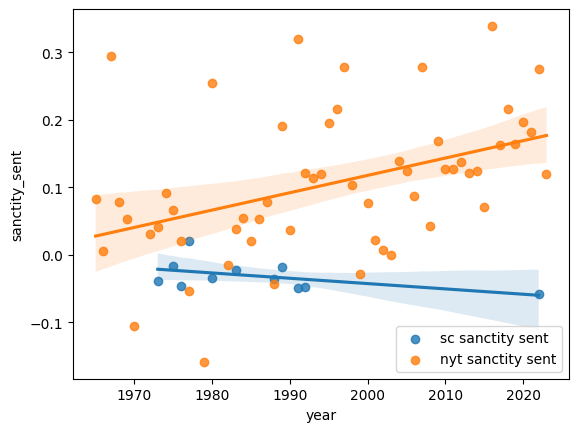

In [ ]:
import seaborn as sns
sns.regplot(data=sc_tmp, x=sc_tmp.index, y='sanctity_sent', label='sc sanctity sent')
sns.regplot(data=nyt_tmp, x=nyt_tmp.index, y='sanctity_sent', label='nyt sanctity sent')
plt.legend()
plt.show()